In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://keras.io/examples/vision/captcha_ocr
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data preparation

In [4]:
import os
import re
from pathlib import Path
from collections import defaultdict

DATA_PATH = '../../Dataset/trdg'
FONT_PATH = '../../Dataset/NomNaTong-Regular.ttf'

## Load the data

In [5]:
def create_dataset(img_paths):
    paths, labels = [], []
    vocabs = defaultdict(int)
    
    for path in img_paths:
        if os.path.getsize(path):
            paths.append(path)
            label = re.sub('_.*', '', os.path.basename(path))
            labels.append(label)
            for char in label: vocabs[char] += 1
    
    vocabs = dict(sorted(
        vocabs.items(), 
        key = lambda item: item[1], 
        reverse = True
    ))    
    return np.array(paths), np.array(labels), vocabs

In [6]:
img_paths = list(map(str, Path(DATA_PATH).glob('*.jpg')))
img_paths, labels, vocabs = create_dataset(img_paths)

print('Number of training images:', len(img_paths))
print('Number of training labels:', len(labels))
print('Number of training vocabs:', len(vocabs))
print('Vocabularies in the training data:\n', vocabs, sep='')

Number of training images: 4434
Number of training labels: 4434
Number of training vocabs: 3291
Vocabularies in the training data:
{'㐌': 316, '浪': 300, '朱': 247, '\U000f047c': 214, '\U000f070b': 213, '尼': 210, '吏': 200, '𦋦': 197, '𢚸': 197, '娘': 197, '𠊛': 192, '固': 189, '拱': 172, '之': 167, '情': 161, '埃': 161, '買': 151, '芇': 146, '𠬠': 145, '仙': 139, '欺': 138, '群': 136, '𠳒': 136, '麻': 130, '𠓨': 127, '𧗱': 124, '爫': 122, '別': 118, '塘': 117, '花': 114, '𠫾': 109, '𠄩': 108, '払': 106, '渚': 106, '𡗶': 106, '浽': 104, '傷': 103, '強': 102, '呐': 101, '渃': 99, '𦖑': 99, '饒': 97, '庒': 97, '如': 96, '些': 95, '分': 94, '冲': 94, '畧': 93, '咍': 92, '鐄': 90, '時': 90, '昆': 90, '低': 90, '𢬣': 89, '𡢐': 88, '身': 87, '兜': 87, '𧡊': 86, '於': 86, '細': 84, '生': 81, '月': 79, '公': 78, '戈': 78, '皮': 78, '調': 76, '﨤': 74, '𣈜': 74, '爲': 73, '茹': 73, '沛': 73, '牢': 73, '仍': 73, '油': 73, '命': 72, '排': 70, '典': 66, '包': 66, '娥': 65, '碎': 65, '㗂': 64, '\U000f061a': 63, '雲': 62, '𠁀': 61, '\U000f02c7': 61, '恩': 61, '迻': 59, '耒': 59, '

## Dataset splitting

In [7]:
def split_data(img_paths, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(img_paths)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle: np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = img_paths[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = img_paths[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [8]:
x_train, x_valid, y_train, y_valid = split_data(img_paths, labels, train_size=0.95)
x_valid, x_test, y_valid, y_test = split_data(x_valid, y_valid, train_size=0.5)

print('Total training samples:', len(x_train))
print('Total validation samples:', len(x_valid))
print('Total testing samples:', len(x_test))

Total training samples: 4212
Total validation samples: 111
Total testing samples: 111


## Building the character vocabulary

In [9]:
# Mapping characters to integers
char_to_num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

## Preprocessing

In [10]:
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char_to_num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
HEIGHT = 148
WIDTH = 32

In [11]:
def distortion_free_resize(image, img_size):
    h, w = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top, pad_height_bottom = height + 1, height
    else: pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left, pad_width_right = width + 1, width
    else: pad_width_left = pad_width_right = pad_width // 2

    return tf.pad(image, paddings=[
        [pad_height_top, pad_height_bottom],
        [pad_width_left, pad_width_right],
        [0, 0],
    ], constant_values = 255) # Pad with white color

In [12]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    
    label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

## Prepare `tf.data.Dataset` objects

In [13]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [14]:
train_tf_dataset = prepare_tf_dataset(x_train, y_train)
valid_tf_dataset = prepare_tf_dataset(x_valid, y_valid)
test_tf_dataset = prepare_tf_dataset(x_test, y_test)
train_tf_dataset

<PrefetchDataset shapes: {image: (None, None, None, 1), label: (None, None), label_length: (None,)}, types: {image: tf.float32, label: tf.int64, label_length: tf.int32}>

## Visualize the data

In [15]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

NROWS, NCOLS = (2, 8)
assert NROWS * NCOLS <= BATCH_SIZE, f'NROWS * NCOLS must be <= {BATCH_SIZE}'
fontdict = {
    'fontproperties': FontProperties(fname=FONT_PATH),
    'fontsize': 18,
    'color': 'black',
    'verticalalignment': 'top',
    'horizontalalignment': 'left'
}

In [17]:
def visualize_batch(
    batch_images, batch_labels, pred_texts=None,
    batch_size=BATCH_SIZE, nrows=NROWS, ncols=NCOLS
):
    for i in range(min(nrows * ncols, batch_size)):
        plt.subplot(nrows, ncols, i + 1)
        img = (batch_images[i] * 255.0).numpy().astype(np.uint8)
        plt.imshow(img[:, :, 0], cmap='gray')

        # Gather indices where label != padding_token.
        indices = tf.gather(
            batch_labels[i], 
            tf.where(tf.math.not_equal(batch_labels[i], PADDING_TOKEN))
        )
        label = tf.strings.reduce_join(num_to_char(indices)) # Convert to string
        label = label.numpy().decode('utf-8')
        
        if pred_texts: draw_predicted_text(pred_texts, label, i) # Defined below
        else: plt.text(WIDTH + 3, 0, '\n'.join(label), fontdict=fontdict)
        fontdict['color'] = 'black' # Reset the color
        plt.axis('off')

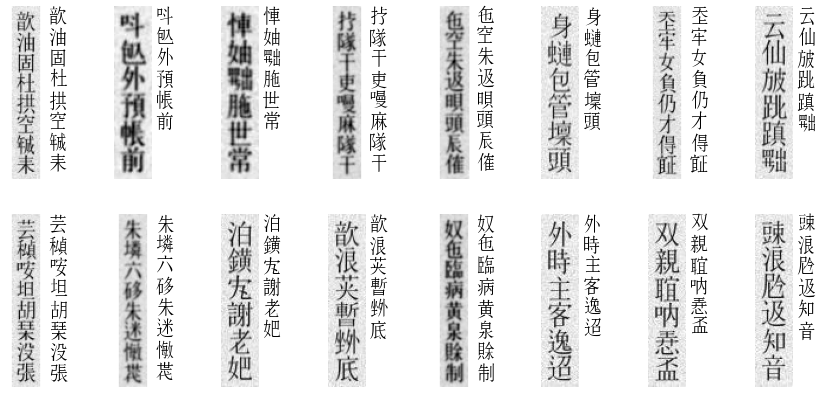

In [18]:
for batch in train_tf_dataset.take(1):
    plt.figure(figsize=(15, 7))
    batch_images, batch_labels = batch['image'], batch['label']
    visualize_batch(batch_images, batch_labels)

# Define the model

In [19]:
from tensorflow.keras.layers import (
    Input, BatchNormalization, LeakyReLU, Reshape,
    Conv2D, MaxPooling2D, Dense, Bidirectional, GRU
)
from tensorflow.keras.models import Model

## CTC Loss

In [20]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name='ctc_loss', **kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, label_length):
        batch_length = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        input_length *= tf.ones(shape=(batch_length, 1), dtype='int64')
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred # At test time, just return the computed predictions.

## CRNN

In [21]:
def build_model(config, optimizer, name):
    image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int32', name='label_length')
    
    # Convolution layer with BatchNormalization and LeakyReLU activation
    def conv2D_bn(input_layer, filters, block_name, conv_idx=''):
        x = Conv2D(
            filters = filters, 
            kernel_size = (2, 2) if block_name == 'final' else (3, 3), 
            padding = 'same', 
            kernel_initializer = 'he_uniform',
            name = f'{block_name}_conv{conv_idx}'
        )(input_layer)
        x = BatchNormalization(name=f'{block_name}_bn{conv_idx}')(x)
        return LeakyReLU(alpha=0.1, name=f'{block_name}_activation{conv_idx}')(x)

    # Generate Convolutional blocks by config
    for idx, (block_name, block_config) in enumerate(config['conv_blocks'].items()):
        num_conv, filters = block_config
        for conv_idx in range(num_conv):
            input_layer = image_input if idx == 0 and conv_idx == 0 else x
            x = conv2D_bn(input_layer, filters, block_name, conv_idx + 1)
        x = MaxPooling2D(pool_size=(2, 2), name=f'{block_name}_pool')(x)
        
    # Last Convolutional block has 2x2 kernel and not contain the MaxPooling layer
    x = conv2D_bn(x, filters * 2, 'final') 
    
    # Reshape accordingly before passing the output to the RNN part
    _, height, width, channel = x.get_shape()
    x = Reshape(target_shape=(height, width * channel), name='rnn_input')(x)

    # RNN layers
    for idx in range(config['rnn_deep_num']):
        x = Bidirectional(GRU(
            units = channel // (idx + 1), 
            return_sequences = True, 
            dropout = 0.3
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char_to_num.vocabulary_size() + 1, 
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)
    
    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    model.compile(optimizer=optimizer)
    return model, Model(inputs=image_input, outputs=y_pred)

## Evaluation metric

In [22]:
validate_images = []
validate_labels = []
for batch in valid_tf_dataset:
    validate_images.append(batch['image'])
    validate_labels.append(batch['label'])

In [23]:
class EditDistanceCompute(tf.keras.callbacks.Callback):
    def __init__(self, prediction_model):
        self.prediction_model = prediction_model
        self.logs = []

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []
        for i in range(len(validate_images)):
            # Make predictions and convert them to sparse tensors.
            preds = self.prediction_model.predict(validate_images[i])
            preds_decoded = tf.keras.backend.ctc_decode(
                preds, 
                input_length = np.ones(preds.shape[0]) * preds.shape[1], 
                greedy = True
            )[0][0][:, :MAX_LENGTH]
            
            # Get a single batch and convert its labels to sparse tensors.
            sparse_labels = tf.sparse.from_dense(validate_labels[i])
            sparse_preds = tf.sparse.from_dense(preds_decoded)

            # Compute individual edit distances and average them out.
            edist = tf.edit_distance(
                tf.cast(sparse_preds, dtype='int64'), 
                tf.cast(sparse_labels, dtype='int64'), 
                normalize = False
            )
            edit_distances.append(tf.reduce_mean(edist).numpy())
            
        mean_edist = np.mean(edit_distances)
        self.logs.append(mean_edist)
        print(' - Mean edit distance:', mean_edist)

# Training

## Build the model

Generate Convolutional blocks and Bidirectional RNN layers by the following format:

    config = {
        'conv_blocks': {
            Name of the convolutional block: [
                Number of "conv2D_bn" layers,
                Number of filters for each "conv2D_bn" layer
            ]
        },
        'rnn_deep_num': Number of Bidirectional RNN layers
    }

In [24]:
from tensorflow.keras.optimizers import Adam
config = {
    'conv_blocks': {
        'bl1': [2, 64],  # block 1 with 2 "conv2D_bn" layers,  64 filters for each
        'bl2': [2, 128], # block 2 with 2 "conv2D_bn" layers, 128 filters for each
        'bl3': [2, 256], # block 3 with 2 "conv2D_bn" layers, 256 filters for each
    },
    'rnn_deep_num': 1 # Number of Bidirectional RNN layers
}
optimizer = Adam(learning_rate=2e-4)
model, prediction_model = build_model(config, optimizer, name='CRNN_OCR')
model.summary()                                

Model: "CRNN_OCR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 148, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 bl1_conv1 (Conv2D)             (None, 148, 32, 64)  640         ['image[0][0]']                  
                                                                                                  
 bl1_bn1 (BatchNormalization)   (None, 148, 32, 64)  256         ['bl1_conv1[0][0]']              
                                                                                                  
 bl1_activation1 (LeakyReLU)    (None, 148, 32, 64)  0           ['bl1_bn1[0][0]']         

## Callbacks

In [25]:
from tensorflow.train import CheckpointOptions
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, 
    LearningRateScheduler, ReduceLROnPlateau
)

In [26]:
checkpoint_path = 'checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Prevent from UnimplementedError when using TPU
options = CheckpointOptions(experimental_io_device='/job:localhost')

# Create a callback that saves the model's weights every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path, 
    save_best_only = True,
    save_weights_only = True,
    save_freq = 10 * len(x_train) // BATCH_SIZE, 
    options = options,  
    verbose = 1
)

In [27]:
def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

In [28]:
edit_distance_callback = EditDistanceCompute(prediction_model)        
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss', 
    patience = 5, # Stop if no improvement after 5 epochs
    min_delta = 0.0001, # The val_loss should at least improve 0.0001
    restore_best_weights = True, 
    verbose = 1
)

## `Model.fit` the CRNN 

In [29]:
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = 100,
    callbacks = [
#         checkpoint_callback,
#         schedule_lr_callback, 
        reduce_lr_callback, 
        edit_distance_callback, 
        early_stopping_callback,
    ],
    verbose = 1
)
model.save('crnn.h5')

Epoch 1/100
264/264 [==============================] - 19s 36ms/step - loss: 52.0146 - val_loss: 55.8366 - lr: 2.0000e-04
Epoch 2/100
264/264 [==============================] - 7s 28ms/step - loss: 32.3500 - val_loss: 21.5774 - lr: 2.0000e-04
Epoch 3/100
264/264 [==============================] - 7s 28ms/step - loss: 14.3558 - val_loss: 12.3360 - lr: 2.0000e-04
Epoch 4/100
264/264 [==============================] - 7s 28ms/step - loss: 7.3320 - val_loss: 8.3511 - lr: 2.0000e-04
Epoch 5/100
264/264 [==============================] - 7s 27ms/step - loss: 4.0328 - val_loss: 6.6834 - lr: 2.0000e-04
Epoch 6/100
264/264 [==============================] - 7s 28ms/step - loss: 2.2290 - val_loss: 5.5438 - lr: 2.0000e-04
Epoch 7/100
264/264 [==============================] - 7s 28ms/step - loss: 1.2035 - val_loss: 5.0049 - lr: 2.0000e-04
Epoch 8/100
264/264 [==============================] - 7s 28ms/step - loss: 0.6237 - val_loss: 4.6271 - lr: 2.0000e-04
Epoch 9/100
264/264 [====================

Epoch 00036: early stopping


## Visualize training result

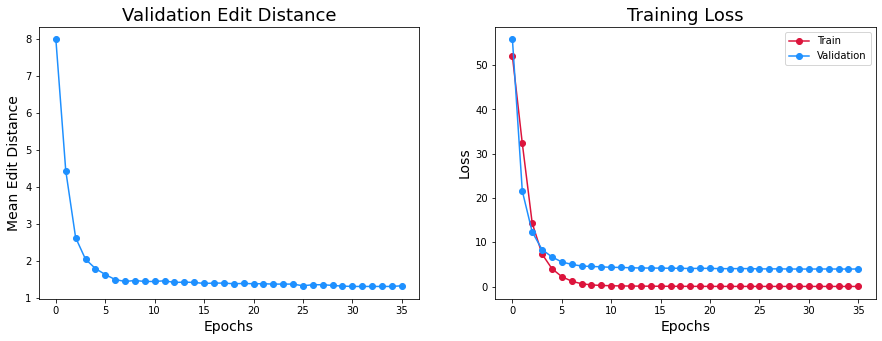

In [30]:
fig = plt.figure(figsize=(15, 5))
loss, val_loss = history.history['loss'], history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(edit_distance_callback.logs, linestyle='solid', marker='o', color='dodgerblue')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Mean Edit Distance',fontsize=14)
plt.title('Validation Edit Distance', fontsize=18)

plt.subplot(1, 2, 2)
plt.plot(loss, linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(val_loss, linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Training Loss', fontsize=18)
plt.legend(loc='best')

fig.savefig('crnn_history.png', bbox_inches='tight') 
plt.show()

# Inference

In [32]:
# A utility function to decode the output of the network
def decode_batch_predictions(preds):
    # Use greedy search. For complex tasks, you can use beam search
    preds_decoded = tf.keras.backend.ctc_decode(
        preds, 
        input_length = np.ones(preds.shape[0]) * preds.shape[1], 
        greedy = True
    )[0][0][:, :MAX_LENGTH]
    
    # Iterate over the results and get back the text
    output_text = []
    for result in preds_decoded:
        result = tf.gather(result, tf.where(tf.math.not_equal(result, -1)))
        result = tf.strings.reduce_join(num_to_char(result))
        output_text.append(result.numpy().decode('utf-8'))
    return output_text

## Reload the model

In [33]:
reloaded_model = tf.keras.models.load_model('crnn.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary()

Model: "CRNN_OCR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 148, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 bl1_conv1 (Conv2D)             (None, 148, 32, 64)  640         ['image[0][0]']                  
                                                                                                  
 bl1_bn1 (BatchNormalization)   (None, 148, 32, 64)  256         ['bl1_conv1[0][0]']              
                                                                                                  
 bl1_activation1 (LeakyReLU)    (None, 148, 32, 64)  0           ['bl1_bn1[0][0]']         

## Function to draw each predicted character

In [183]:
from matplotlib.patches import Patch
mpatches_handles = [
    Patch(color='green', label='Full match'), 
    Patch(color='dodgerblue', label='Character match'),
    Patch(color='red', label='Wrong prediction'),
    Patch(color='black', label='Actual character'),
    Patch(color='gray', label='Missing position'),
]

In [184]:
def draw_predicted_text(pred_texts, label, image_idx):
    text, pos_x = pred_texts[image_idx], WIDTH + 3
    if text != label: 
        start, end = 0, 0
        while start <= end < len(label):
            pos_y = end * 18.5
            if label[start:end+1] in text:
                fontdict['color'] = 'dodgerblue'
                plt.text(pos_x, pos_y, label[end], fontdict=fontdict)
            else: 
                if end + 1 < len(label) and text[end] == label[end + 1]:
                    fontdict['color'] = 'gray'
                    plt.text(pos_x, pos_y, label[end], fontdict=fontdict)
                else:
                    fontdict['color'] = 'red'
                    plt.text(pos_x, pos_y, text[end], fontdict=fontdict)
                    fontdict['color'] = 'black'
                    plt.text(pos_x + 20, pos_y, label[end], fontdict=fontdict)
                start = end + 1
            end += 1
    else: 
        fontdict['color'] = 'green'
        plt.text(pos_x, 0, '\n'.join(text), fontdict=fontdict)

## On test dataset

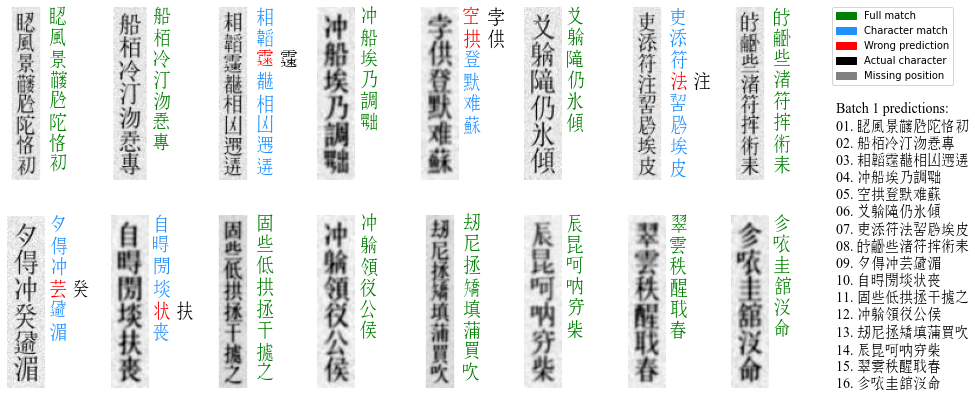

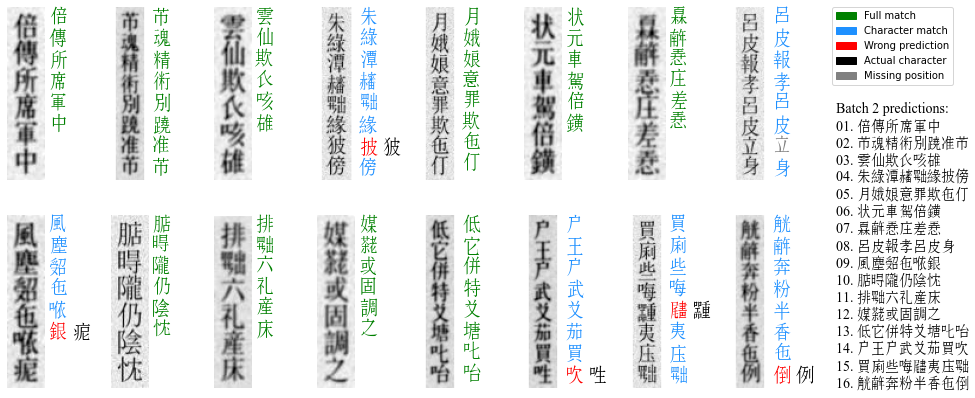

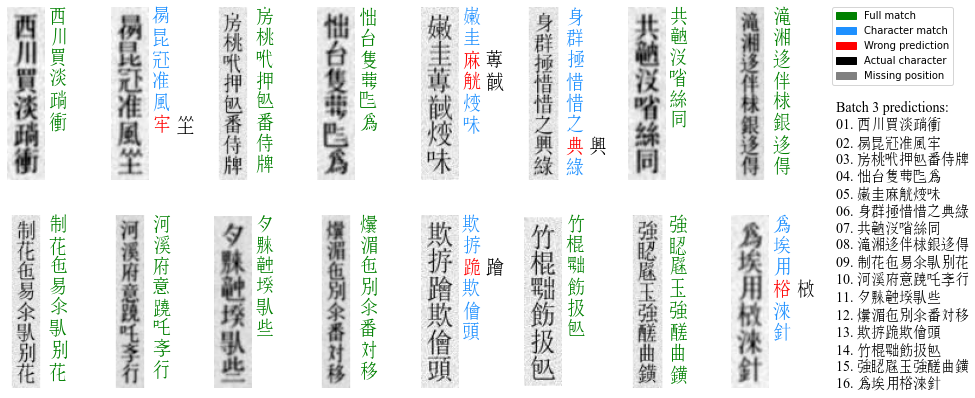

In [185]:
for idx, batch in enumerate(test_tf_dataset.take(3)):
    batch_images, batch_labels = batch['image'], batch['label']
    # preds = prediction_model.predict(batch_images)
    preds = reloaded_prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    plt.figure(figsize=(15, 7))
    plt.subplots_adjust(left=0, right=0.75)        
    visualize_batch(batch_images, batch_labels, pred_texts)
    
    plt.legend(handles=mpatches_handles, loc=(2.7, 1.75))
    annotate_text = [f'{idx + 1:02d}. {text}' for idx, text in enumerate(pred_texts)]
    plt.annotate(
        f"Batch {idx + 1} predictions:\n{chr(10).join(annotate_text)}", 
        fontproperties = FontProperties(fname=FONT_PATH),
        xycoords = 'axes fraction', 
        fontsize = 14, 
        xy = (2.8, 0), 
    )

## On random image